# Preparation and testing of model specification

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
from pathlib import Path
from time import time

import aesara
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from matplotlib.lines import Line2D

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.


In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import DataFile, data_path
from speclet.loggers import set_console_handler_level
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Logging.
set_console_handler_level("DEBUG")
aesara.config.exception_verbosity = "high"

# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
SEED = 847
np.random.seed(SEED)
arviz_config()

## Data

In [5]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df.query("screen == 'broad'").reset_index(drop=True)

In [6]:
crispr_data_manager = CrisprScreenDataManager(
    DataFile.DEPMAP_CRC_SUBSAMPLE, transformations=[_broad_only]
)
crc_data = crispr_data_manager.get_data()

In [7]:
for col in ["sgrna", "hugo_symbol", "depmap_id"]:
    print(f"'{col}': {crc_data[col].nunique()}")

'sgrna': 162
'hugo_symbol': 103
'depmap_id': 8


## Distributions

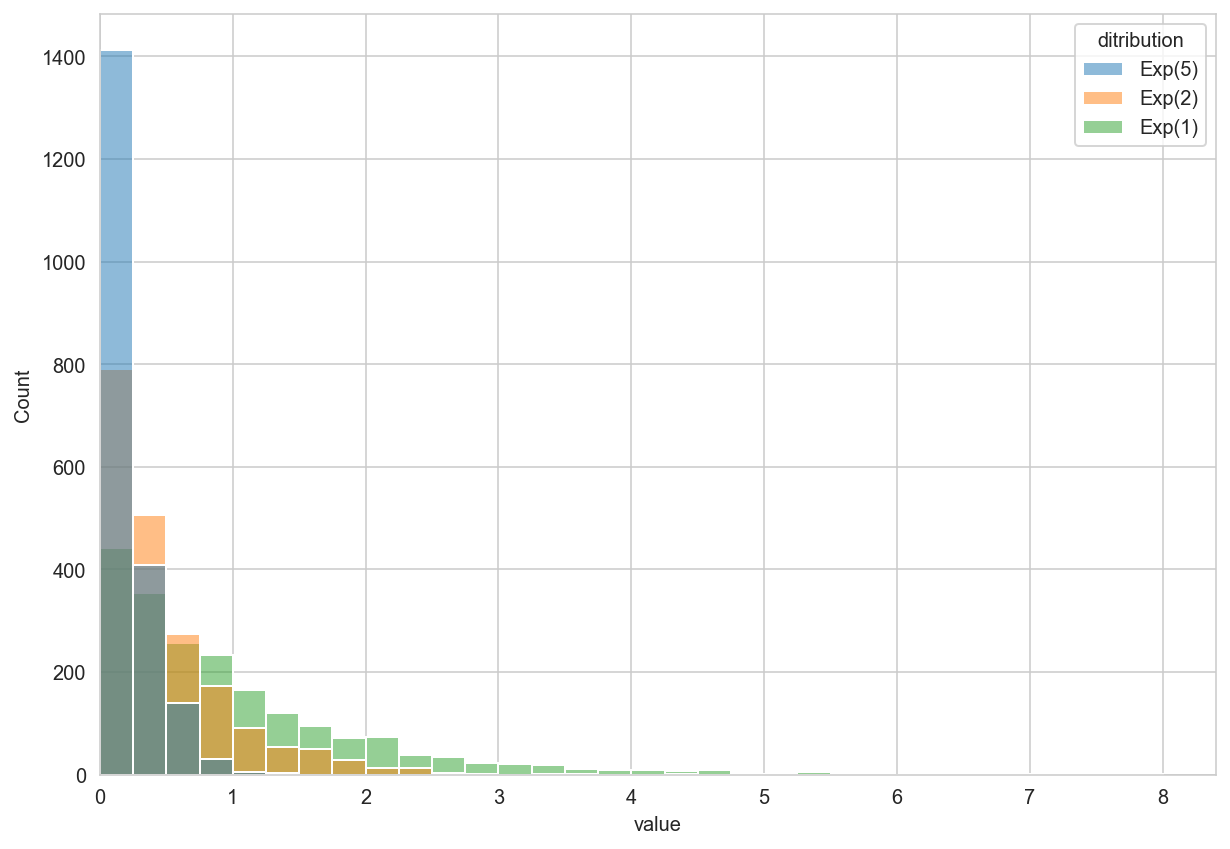

In [8]:
N = 2000
df = pd.DataFrame()
df = pd.concat(
    [
        df,
        # pd.DataFrame({"value": pm.draw(pm.HalfNormal.dist(0.5), N), "dist": "HN(0.5)"}),
        pd.DataFrame({"value": pm.draw(pm.Exponential.dist(5), N), "dist": "Exp(5)"}),
        pd.DataFrame({"value": pm.draw(pm.Exponential.dist(2), N), "dist": "Exp(2)"}),
        pd.DataFrame({"value": pm.draw(pm.Exponential.dist(1), N), "dist": "Exp(1)"}),
        # pd.DataFrame(
        #     {"value": pm.draw(pm.Exponential.dist(0.2), N), "dist": "Exp(0.5)"}
        # ),
        # pd.DataFrame({"value": pm.draw(pm.Gamma.dist(2, 1), N), "dist": "Gamma(2,1)"}),
        # pd.DataFrame({"value": pm.draw(pm.Gamma.dist(3, 1), N), "dist": "Gamma(3,1)"}),
        # pd.DataFrame({"value": pm.draw(pm.Gamma.dist(3, 2), N), "dist": "Gamma(3,2)"}),
        # pd.DataFrame({"value": pm.draw(pm.Gamma.dist(3, 4), N), "dist": "Gamma(3,4)"}),
        # pd.DataFrame({"value": pm.draw(pm.Gamma.dist(5, 1), N), "dist": "Gamma(5,1)"}),
        # pd.DataFrame(
        #     {"value": pm.draw(pm.Gamma.dist(10, 1), N), "dist": "Gamma(10,1)"}
        # ),
    ]
).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=df, x="value", hue="dist", ax=ax, binwidth=0.25)
ax.get_legend().set_title("ditribution")
ax.set_xlim(0, None)
plt.show()

In [9]:
df.groupby("dist").describe()

value                                                              \
         count      mean       std       min       25%       50%       75%   
dist                                                                         
Exp(1)  2000.0  0.981218  0.993137  0.000033  0.288159  0.693714  1.346334   
Exp(2)  2000.0  0.493076  0.503124  0.000404  0.137649  0.335328  0.662969   
Exp(5)  2000.0  0.201439  0.197024  0.000002  0.055565  0.139255  0.284392   

                  
             max  
dist              
Exp(1)  7.967910  
Exp(2)  4.295236  
Exp(5)  1.339871

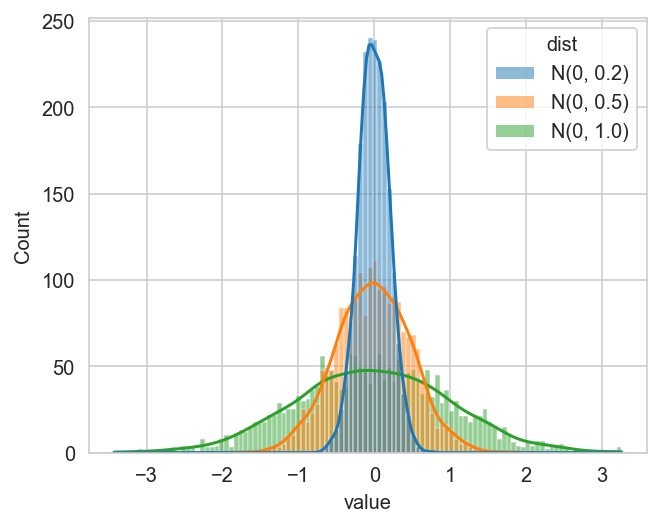

In [10]:
N = 2000
df = pd.concat(
    [
        pd.DataFrame(
            {"value": pm.draw(pm.Normal.dist(0, 0.2), N), "dist": "N(0, 0.2)"}
        ),
        pd.DataFrame(
            {"value": pm.draw(pm.Normal.dist(0, 0.5), N), "dist": "N(0, 0.5)"}
        ),
        pd.DataFrame({"value": pm.draw(pm.Normal.dist(0, 1), N), "dist": "N(0, 1.0)"}),
    ]
).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5, 4))
sns.histplot(data=df, x="value", hue="dist", ax=ax, kde=True)
plt.show()

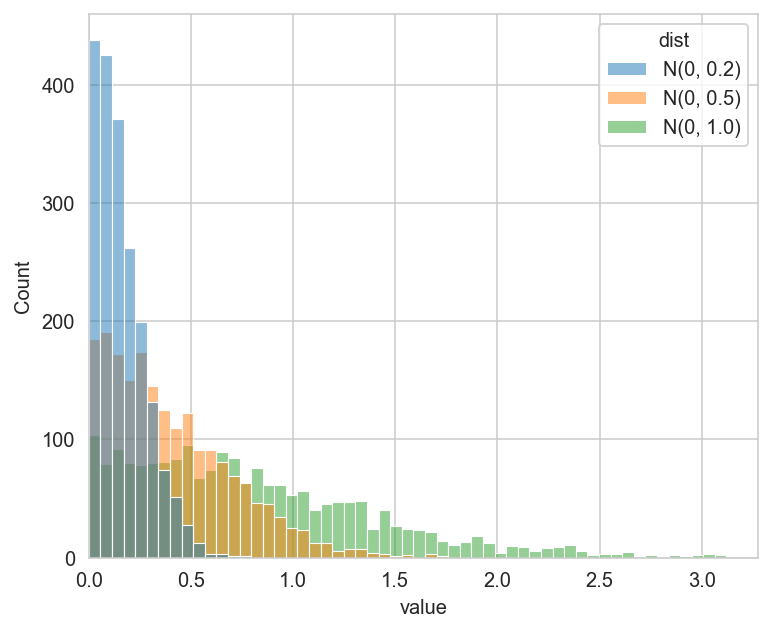

In [11]:
N = 2000


def _hn(sigma: float) -> pd.DataFrame:
    return pd.DataFrame(
        {"value": pm.draw(pm.HalfNormal.dist(sigma=sigma), N), "dist": f"N(0, {sigma})"}
    )


df = pd.concat([_hn(s) for s in [0.2, 0.5, 1.0]]).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6, 5))
sns.histplot(data=df, x="value", hue="dist", ax=ax, kde=False)
ax.set_xlim(0, None)
plt.show()

In [12]:
df.groupby("dist").describe()

value                                                              \
            count      mean       std       min       25%       50%       75%   
dist                                                                            
N(0, 0.2)  2000.0  0.158821  0.120308  0.000302  0.063685  0.132095  0.228129   
N(0, 0.5)  2000.0  0.401247  0.305430  0.000050  0.155557  0.333818  0.589862   
N(0, 1.0)  2000.0  0.790126  0.588908  0.000014  0.334482  0.676455  1.135809   

                     
                max  
dist                 
N(0, 0.2)  0.780190  
N(0, 0.5)  1.733197  
N(0, 1.0)  3.120721

(0.0, 80.85)

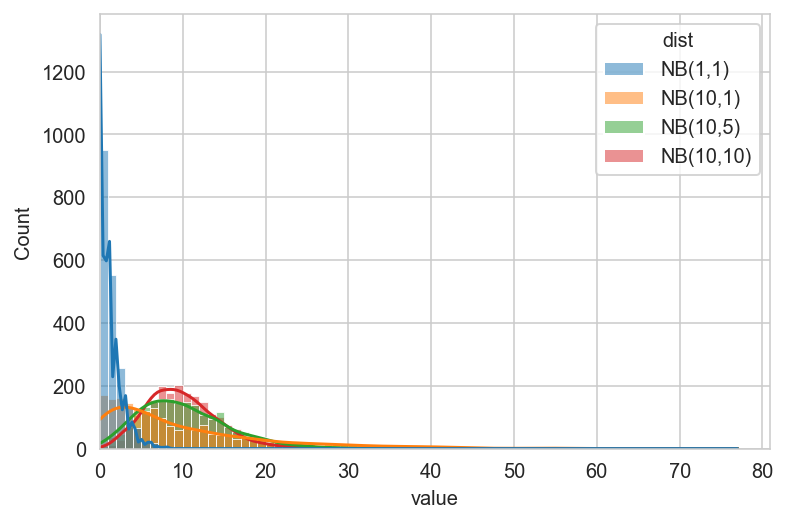

In [13]:
N = 2000
df = pd.DataFrame()
df = pd.concat(
    [
        df,
        pd.DataFrame(
            {"value": pm.draw(pm.NegativeBinomial.dist(1, 1), N), "dist": "NB(1,1)"}
        ),
        pd.DataFrame(
            {"value": pm.draw(pm.NegativeBinomial.dist(10, 1), N), "dist": "NB(10,1)"}
        ),
        pd.DataFrame(
            {"value": pm.draw(pm.NegativeBinomial.dist(10, 5), N), "dist": "NB(10,5)"}
        ),
        pd.DataFrame(
            {
                "value": pm.draw(pm.NegativeBinomial.dist(10, 10), N),
                "dist": "NB(10,10)",
            }
        ),
    ]
)
df = df.reset_index(drop=True)
ax = sns.histplot(data=df, x="value", hue="dist", kde=True, binwidth=1)
ax.set_xlim(0, None)

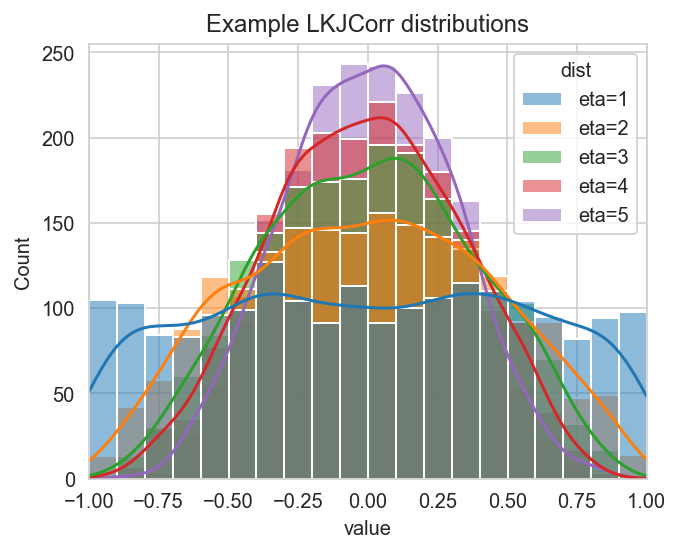

In [14]:
N = 2000


def _lkj(eta: int) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "value": pm.draw(pm.LKJCorr.dist(n=2, eta=eta), N).flatten(),
            "dist": f"eta={eta}",
        }
    )


df = pd.concat([_lkj(i) for i in range(1, 6)]).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5, 4))
sns.histplot(data=df, x="value", hue="dist", kde=True, binwidth=0.1, ax=ax)
ax.set_xlim(-1, 1)
ax.set_title("Example LKJCorr distributions")
plt.show()

In [15]:
df.groupby("dist").describe()

value                                                              \
        count      mean       std       min       25%       50%       75%   
dist                                                                        
eta=1  2000.0 -0.000314  0.568824 -0.998872 -0.461132 -0.003937  0.472399   
eta=2  2000.0 -0.002975  0.443332 -0.977707 -0.334833  0.001021  0.341524   
eta=3  2000.0  0.007750  0.375269 -0.931989 -0.274476  0.013630  0.284620   
eta=4  2000.0 -0.005234  0.336725 -0.930971 -0.252810 -0.001786  0.242750   
eta=5  2000.0  0.005697  0.296470 -0.875722 -0.206058  0.008814  0.218636   

                 
            max  
dist             
eta=1  0.999201  
eta=2  0.946646  
eta=3  0.902157  
eta=4  0.831108  
eta=5  0.871636

## Modeling

In [16]:
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel

In [17]:
crc_model = LineageHierNegBinomModel(
    lineage="colorectal", reduce_deterministic_vars=False
)
valid_crc_data = crc_model.data_processing_pipeline(crc_data.copy())

[07/29/22 13:08:54] INFO     Processing data for modeling.     ]8;id=446759;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=182751;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#269\269]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=201630;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=881085;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#270\270]8;;\

                    WARNING  number of data points dropped: 0  ]8;id=407141;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=294585;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#321\321]8;;\

[07/29/22 13:08:55] INFO     Processing data for modeling.     ]8;id=258559;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=94800;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#269\269]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=804068;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=485067;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#270\270]8;;\

                    WARNING  number of data points dropped: 0  ]8;id=147476;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=930176;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#321\321]8;;\

                    INFO     number of genes mutated in all    ]8;id=888589;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=68640;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#478\478]8;;\
                             cells lines: 1                                                  

                    DEBUG    Genes always mutated: APC         ]8;id=783546;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=480854;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#481\481]8;;\

[07/29/22 13:08:56] INFO     Dropping 2 cancer genes.          ]8;id=967018;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=849922;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#534\534]8;;\

                    DEBUG    Dropped cancer genes: ['APC',     ]8;id=921796;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=676165;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#535\535]8;;\
                             'MDM2']                                                         

                    INFO     Lineage: colorectal               ]8;id=631200;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=160535;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#325\325]8;;\

                    INFO     Number of genes: 103              ]8;id=57952;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=138773;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#326\326]8;;\

                    INFO     Number of sgRNA: 162              ]8;id=999839;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=1430;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#327\327]8;;\

                    INFO     Number of cell lines: 8           ]8;id=253098;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=242646;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#328\328]8;;\

                    INFO     Number of cancer genes: 3         ]8;id=713111;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=557532;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#329\329]8;;\

                    INFO     Number of screens: 1              ]8;id=835376;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=533441;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#330\330]8;;\

                    INFO     Number of data points: 1296       ]8;id=809295;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=231582;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#331\331]8;;\

                    INFO     Including all non-essential       ]8;id=105964;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=752470;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#336\336]8;;\
                             deterministic variables.                                        

                    DEBUG    shape of cancer gene matrix:      ]8;id=655747;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=591000;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#371\371]8;;\
                             (1296, 3)                                                       

                    DEBUG    location for `mu_mu_a`: 0.1523    ]8;id=76712;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=699864;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#384\384]8;;\

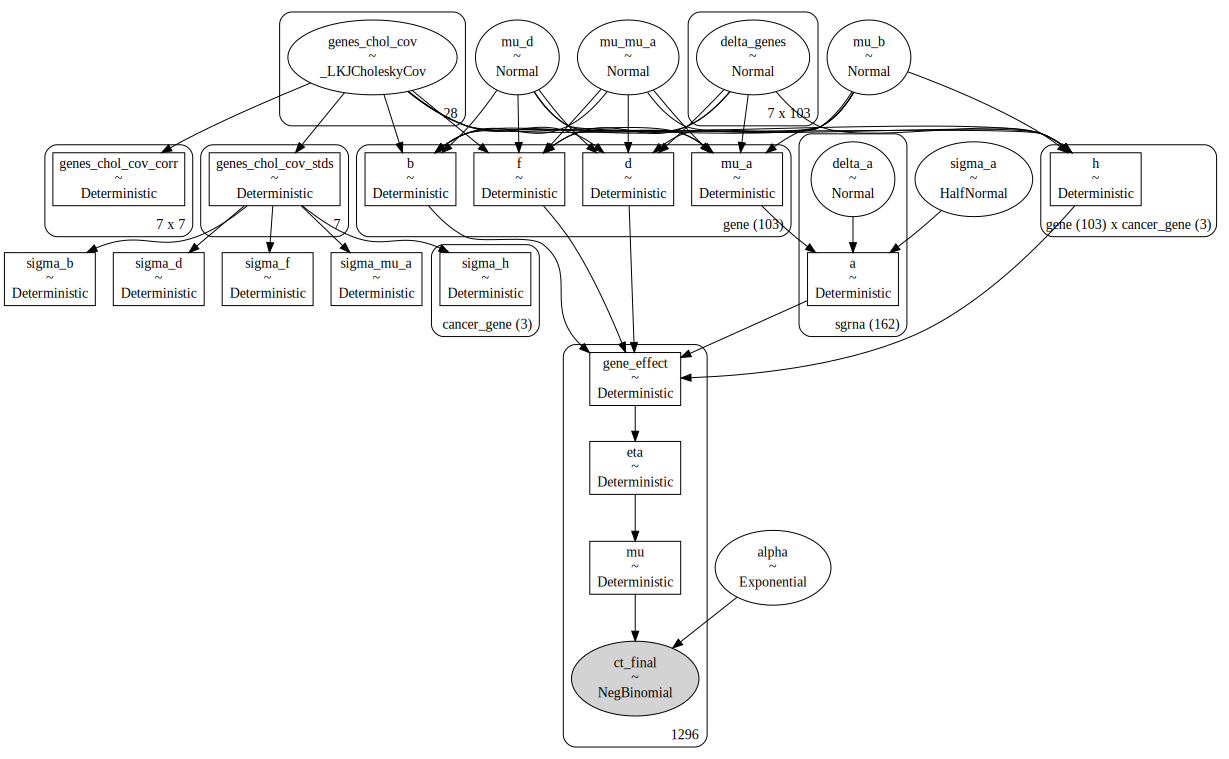

In [18]:
crc_pymc_model = crc_model.pymc_model(crispr_data_manager.data.copy())
pm.model_to_graphviz(crc_pymc_model)

In [19]:
with crc_pymc_model:
    pm_prior_pred = pm.sample_prior_predictive(
        var_names=["eta", "ct_final", "mu_a", "gene_effect"], random_seed=SEED
    )

print("prior predictive distribution")
pm_pred_draws = pm_prior_pred.prior_predictive["ct_final"].values.squeeze()
for q in [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1]:
    res = np.quantile(pm_pred_draws, q=q)
    print(f"  {int(q*100)}%: {int(res):0,d}")

print("")
obs = valid_crc_data["counts_final"].astype(int)
print(f"final counts\n  min: {np.min(obs):,d},  max: {np.max(obs):,d}")

obs = valid_crc_data["counts_initial_adj"].astype(int)
print(f"initial counts\n  min: {np.min(obs):,d},  max: {np.max(obs):,d}")

prior predictive distribution
  0%: 0
  1%: 0
  10%: 9
  20%: 48
  30%: 108
  40%: 192
  50%: 310
  60%: 489
  70%: 780
  80%: 1,328
  90%: 2,780
  99%: 19,484
  100%: 1,023,468,204

final counts
  min: 0,  max: 9,819
initial counts
  min: 57,  max: 4,741


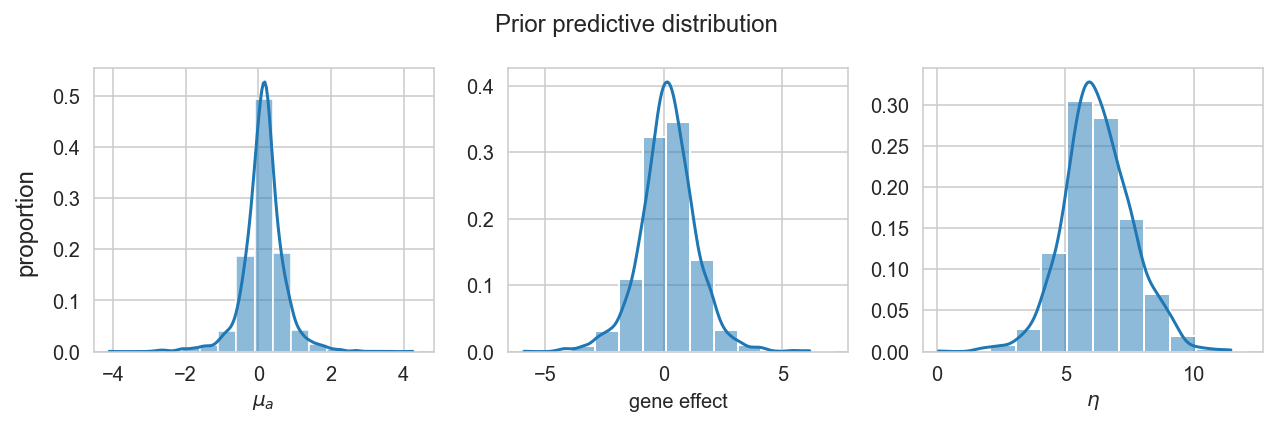

In [20]:
eta_prior = np.random.choice(pm_prior_pred.prior["eta"].values.flatten(), 2000)
ge_prior = np.random.choice(pm_prior_pred.prior["gene_effect"].values.flatten(), 4000)
mu_prior = np.random.choice(pm_prior_pred.prior["mu_a"].values.flatten(), 4000)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3))
sns.histplot(mu_prior, kde=True, ax=axes[0], binwidth=0.5, stat="proportion")
sns.histplot(ge_prior, kde=True, ax=axes[1], binwidth=1, stat="proportion")
sns.histplot(eta_prior, kde=True, ax=axes[2], binwidth=1, stat="proportion")
axes[0].set_xlabel(r"$\mu_a$")
axes[1].set_xlabel(r"gene effect")
axes[2].set_xlabel(r"$\eta$")

for ax in axes.flatten():
    ax.set_ylabel(None)
    ax.set_title(None)

fig.supylabel("proportion")
fig.suptitle("Prior predictive distribution")
fig.tight_layout()
plt.show()

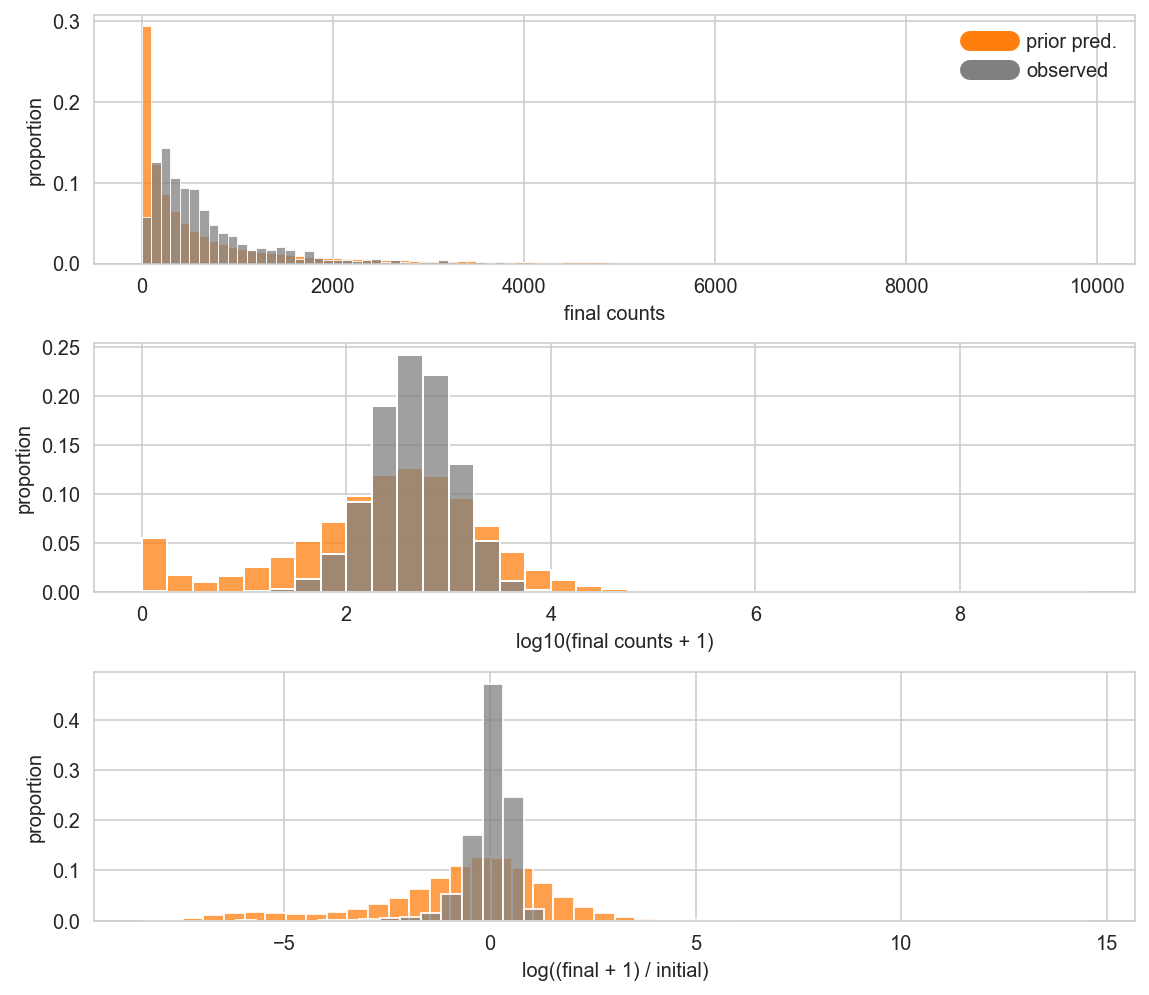

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 7))

stat = "proportion"

obs_max = crc_data["counts_final"].max()
truncated_prior_preds = [x for x in pm_pred_draws.flatten() if x <= obs_max]

prior_pred_pal = {"prior pred.": "tab:orange", "observed": "gray"}

# Untransformed
bw: float = 100
sns.histplot(
    x=truncated_prior_preds,
    ax=axes[0],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["prior pred."],
)
sns.histplot(
    x=valid_crc_data["counts_final"],
    ax=axes[0],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["observed"],
)
# Log10 transformed
bw = 0.25
sns.histplot(
    x=np.log10(pm_pred_draws.flatten() + 1),
    ax=axes[1],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["prior pred."],
)
sns.histplot(
    x=np.log10(valid_crc_data["counts_final"] + 1),
    ax=axes[1],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["observed"],
)
# Log-fold change
pp_lfc = np.log(
    (pm_pred_draws + 1) / (valid_crc_data["counts_initial_adj"].values[None, :])
)
obs_lfc = np.log(
    (valid_crc_data["counts_final"] + 1) / valid_crc_data["counts_initial_adj"]
)
bw = 0.5
sns.histplot(
    x=pp_lfc.flatten(),
    ax=axes[2],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["prior pred."],
)
sns.histplot(
    x=obs_lfc,
    ax=axes[2],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["observed"],
)


axes[0].set_xlabel("final counts")
axes[1].set_xlabel("log10(final counts + 1)")
axes[2].set_xlabel("log((final + 1) / initial)")

prior_pred_leg_handles = [
    Line2D([0], [0], linewidth=10, color=v, label=k) for k, v in prior_pred_pal.items()
]
axes[0].legend(handles=prior_pred_leg_handles, loc="upper right", frameon=False)

for ax in axes.flatten():
    ax.set_ylabel(stat)

plt.tight_layout()
plt.show()

## Sampling

In [22]:
pymc.__file__

'/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/pymc/__init__.py'

In [23]:
with crc_pymc_model:
    trace = pymc.sampling_jax.sample_numpyro_nuts(
        draws=500,
        tune=1000,
        target_accept=0.90,
        random_seed=SEED,
        idata_kwargs={"log_likelihood": False},
        nuts_kwargs={"step_size": 0.1}
        # discard_tuned_samples=False,
    )
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=SEED)

Compiling...
Compilation time =  0:00:11.738092
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling time =  0:01:30.420077
Transforming variables...
Transformation time =  0:00:03.121350


In [24]:
saved_warmup = hasattr(trace, "warmup_sample_stats")

## Posterior analysis

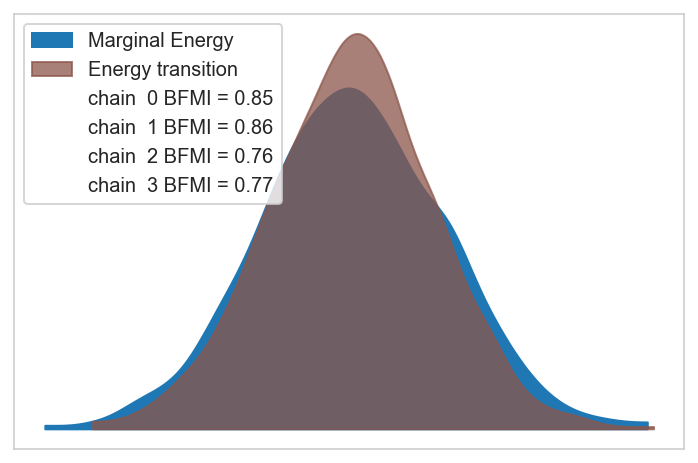

In [25]:
az.plot_energy(trace);

In [26]:
divs = trace.sample_stats["diverging"].values.sum(axis=1)
print(f"divergences: {divs}")

divergences: [0 0 0 0]


In [27]:
if saved_warmup:
    ar = trace.warmup_sample_stats.acceptance_rate.values
    ss = trace.warmup_sample_stats.step_size.values
    n_chains = ss.shape[0]
    x = np.arange(ss.shape[1])
    fig, axes = plt.subplots(n_chains // 2, 2, figsize=(8, 4), sharex=True, sharey=True)
    for c, ax in enumerate(axes.flatten()):
        sns.scatterplot(x=x, y=ar[c, :], color="tab:blue", edgecolor=None, s=2, ax=ax)
        sns.scatterplot(x=x, y=ss[c, :], color="tab:green", edgecolor=None, s=2, ax=ax)

    fig.tight_layout()
    plt.show()

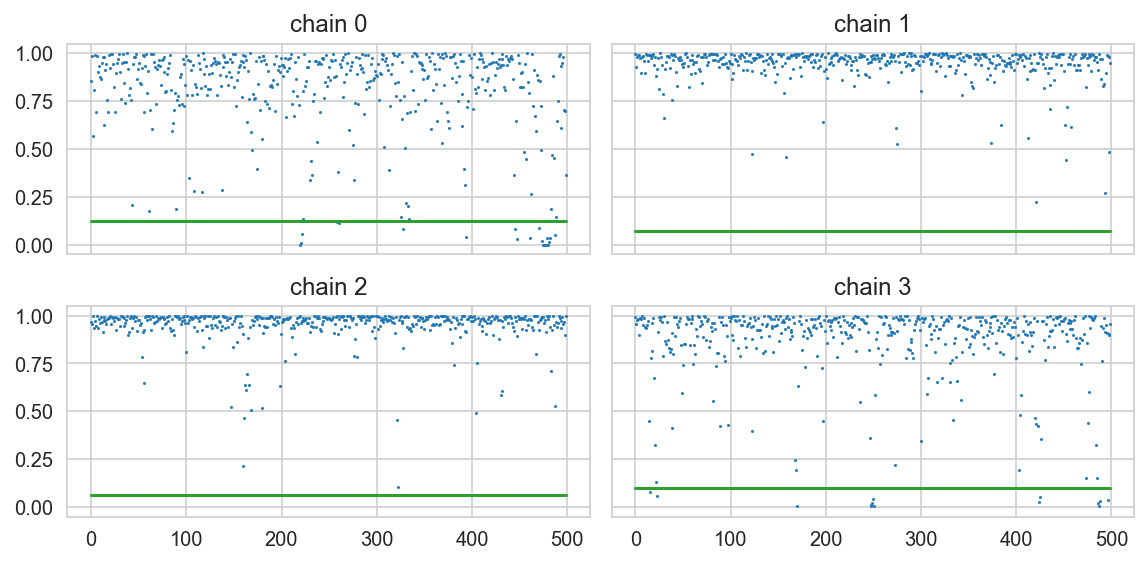

In [28]:
ar = trace.sample_stats.acceptance_rate.values
ss = trace.sample_stats.step_size.values
n_chains = ss.shape[0]
x = np.arange(ss.shape[1])
fig, axes = plt.subplots(n_chains // 2, 2, figsize=(8, 4), sharex=True, sharey=True)
for c, ax in enumerate(axes.flatten()):
    sns.scatterplot(x=x, y=ar[c, :], color="tab:blue", edgecolor=None, s=2, ax=ax)
    sns.scatterplot(x=x, y=ss[c, :], color="tab:green", edgecolor=None, s=2, ax=ax)
    ax.set_title(f"chain {c}")

fig.tight_layout()
plt.show()

In [29]:
stat_cats = ["energy", "step_size", "n_steps", "acceptance_rate"]
trace.sample_stats.get(stat_cats).to_dataframe().groupby("chain").mean().round(3)

energy  step_size  n_steps  acceptance_rate
chain                                                
0      10173.567      0.124   31.000            0.808
1      10168.572      0.075   63.000            0.944
2      10177.420      0.065   63.000            0.951
3      10169.390      0.100   60.568            0.865

In [30]:
np.all(trace.sample_stats.step_size.values.mean(axis=1) > 0.001)

True

In [31]:
if saved_warmup:
    print(trace.warmup_posterior["sigma_mu_a"].values[:, 0:5])

In [32]:
if saved_warmup:
    az.plot_trace(
        trace.warmup_posterior,
        var_names=crc_model.vars_regex() + ["~^h$"],
        filter_vars="regex",
        coords={"draw": list(range(100))},
    )
    plt.tight_layout()
    plt.show()

In [33]:
if saved_warmup:
    az.plot_trace(
        trace.warmup_posterior,
        var_names=crc_model.vars_regex() + ["~^h$"],
        filter_vars="regex",
    )
    plt.tight_layout()
    plt.show()

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/arviz/utils.py:136: UserWarning: Items starting with ~: ['^celllines_chol_cov.*$', '^.*celllines$'] have not been found and will be ignored


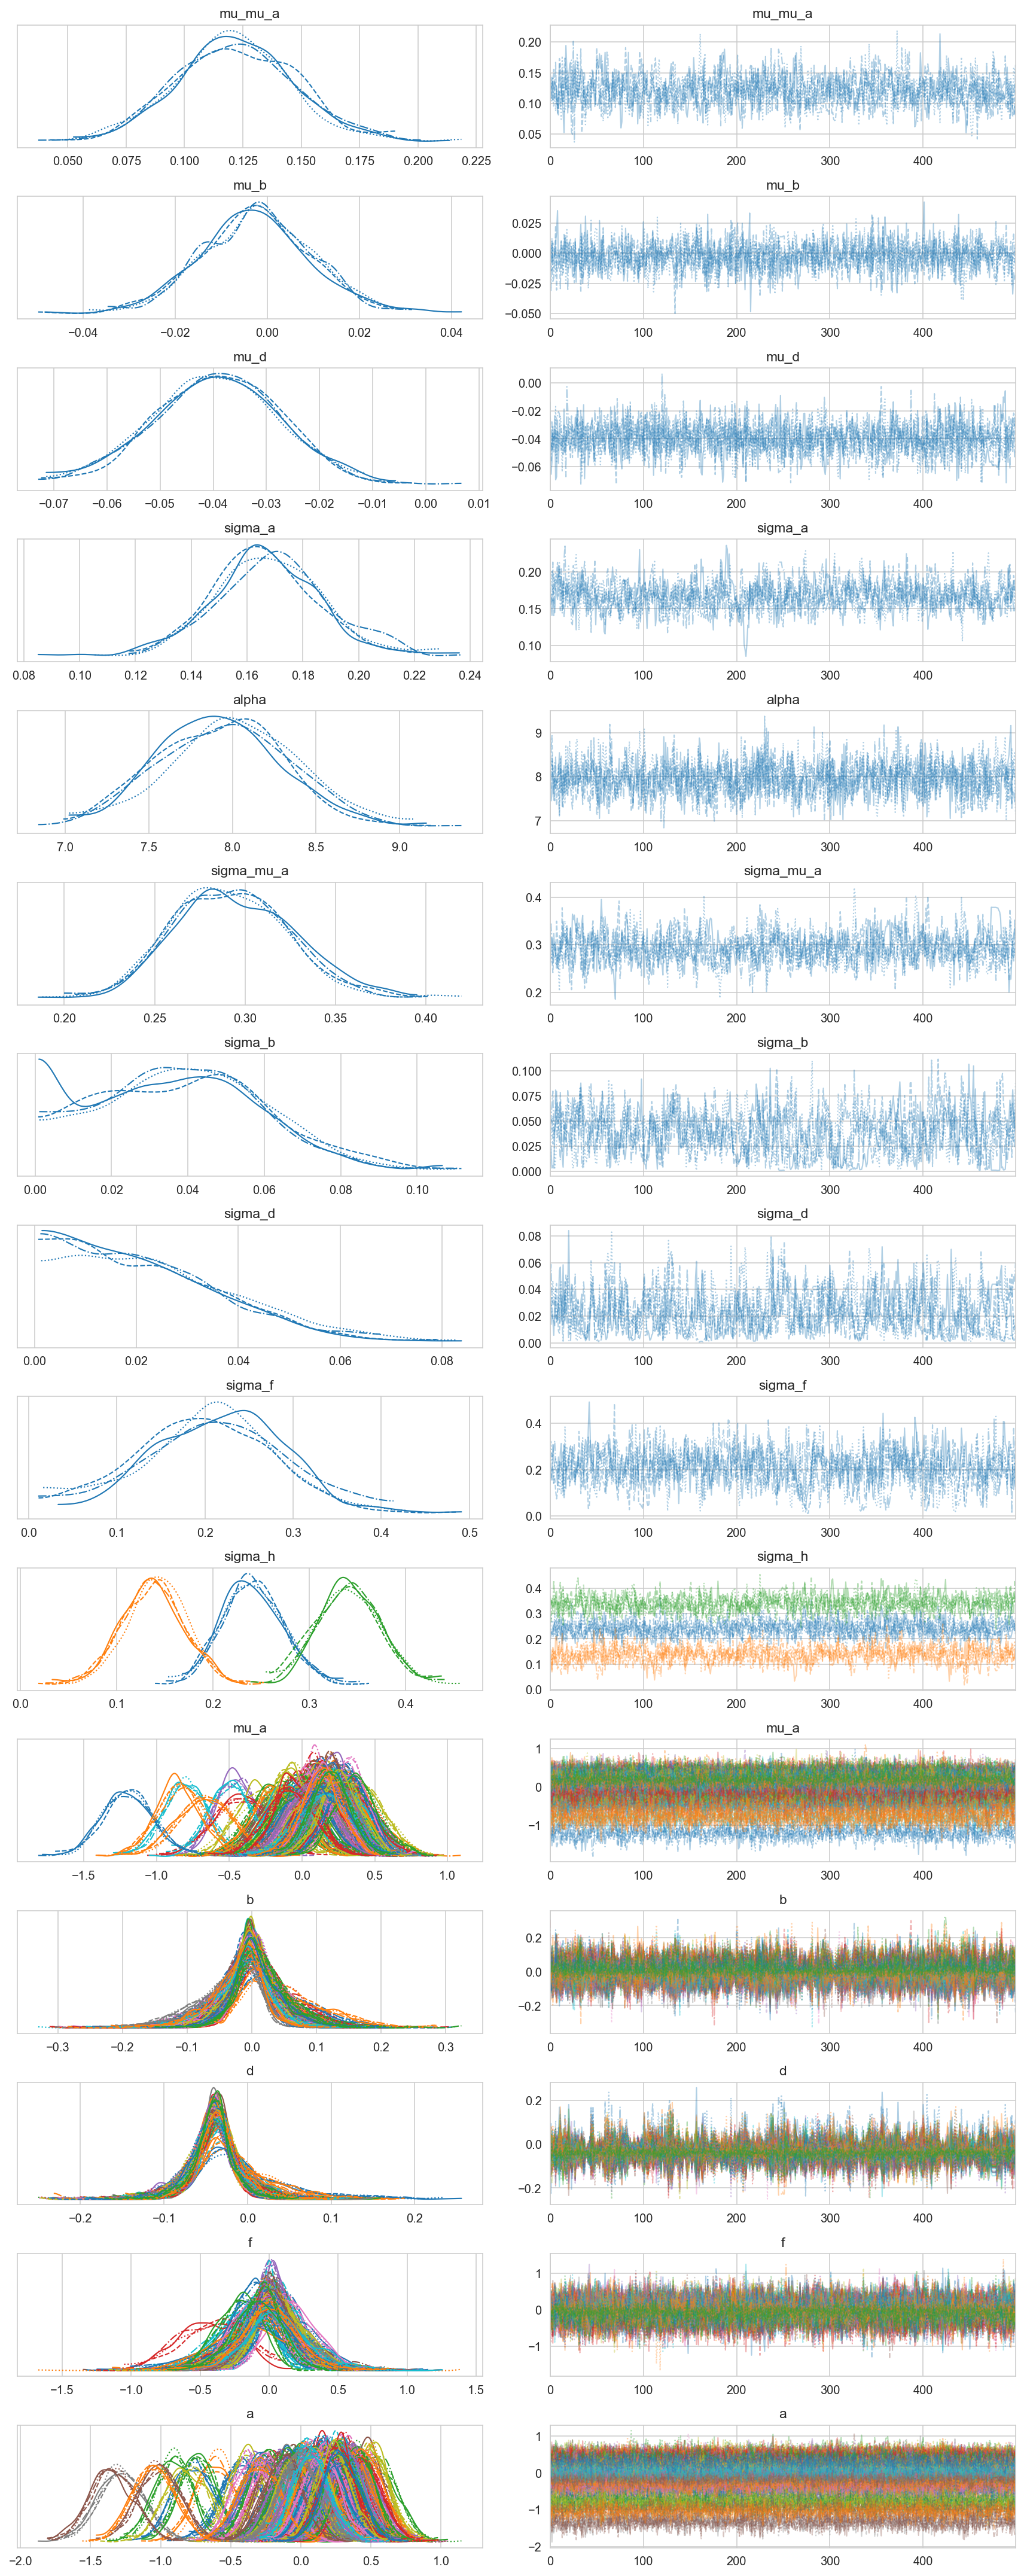

In [34]:
az.plot_trace(trace, var_names=crc_model.vars_regex() + ["~^h$"], filter_vars="regex")
plt.tight_layout();

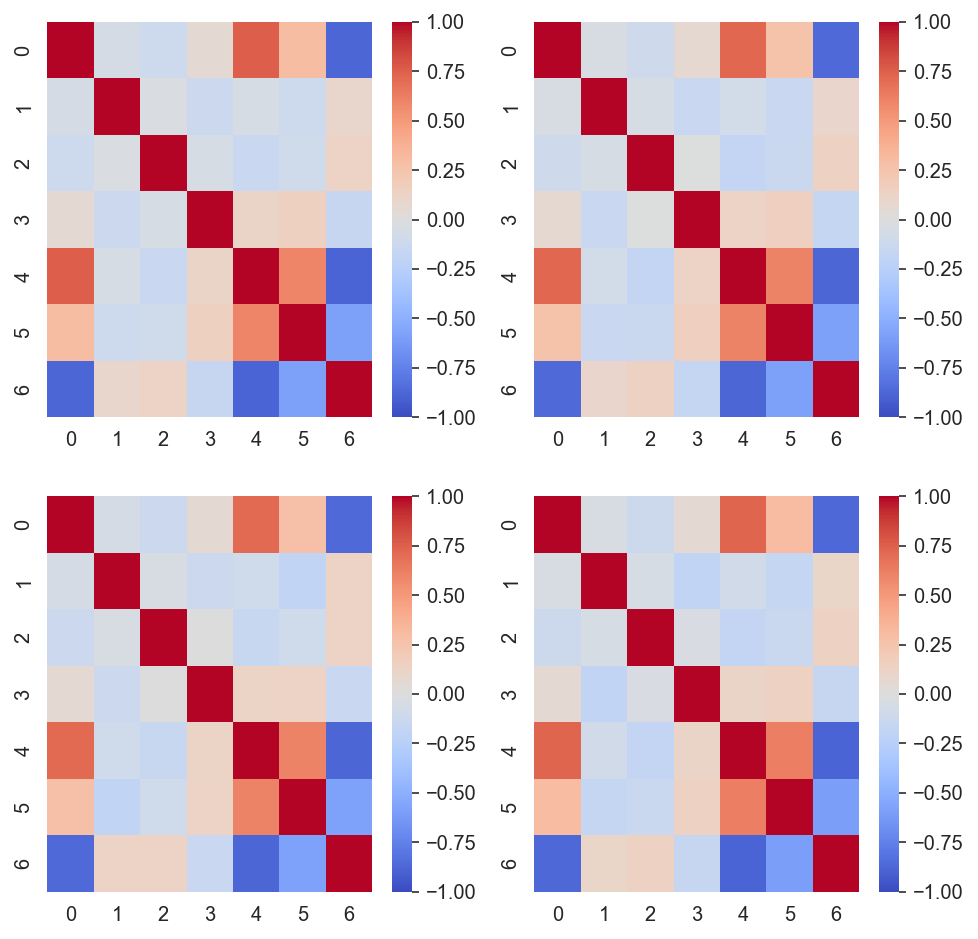

In [35]:
n_chains = len(trace.posterior.coords["chain"])
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for c, ax in enumerate(axes.flatten()):
    cor_mat = trace.posterior["genes_chol_cov_corr"][c, :, :, :].mean(axis=(0))
    # print(cor_mat.shape)
    sns.heatmap(cor_mat, vmin=-1, vmax=1, cmap="coolwarm", ax=ax)

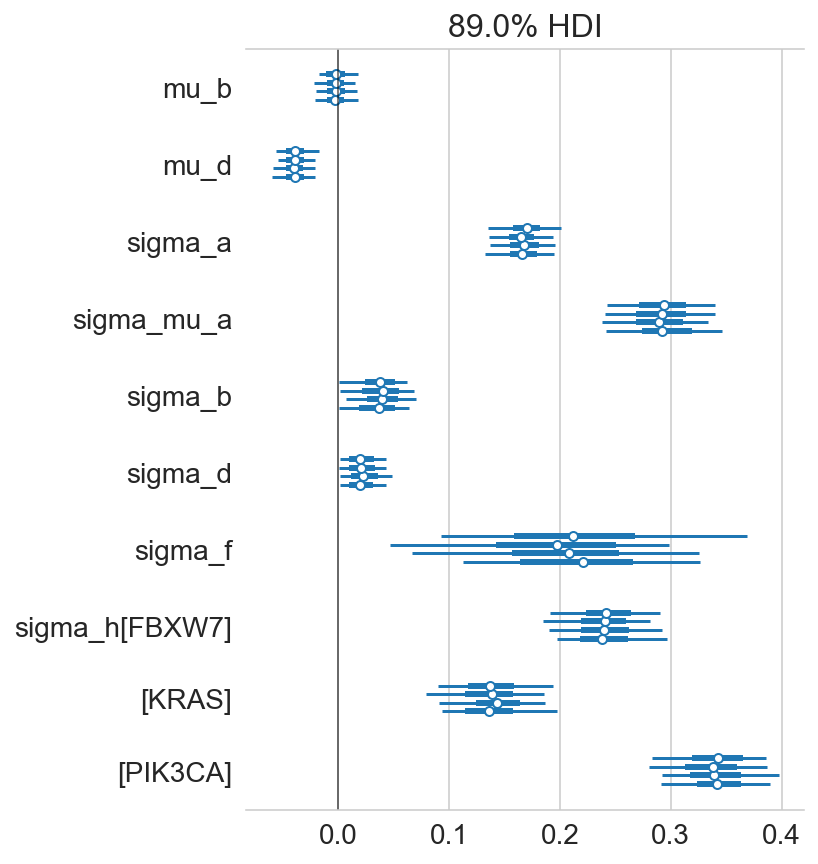

In [36]:
ax = az.plot_forest(
    trace,
    var_names=["mu_b", "mu_d", "mu_f", "mu_h", "^sigma.*$"],
    filter_vars="regex",
    combined=False,
    figsize=(5, 7),
)
ax[0].axvline(color="k", alpha=0.5, linewidth=1)
plt.show()

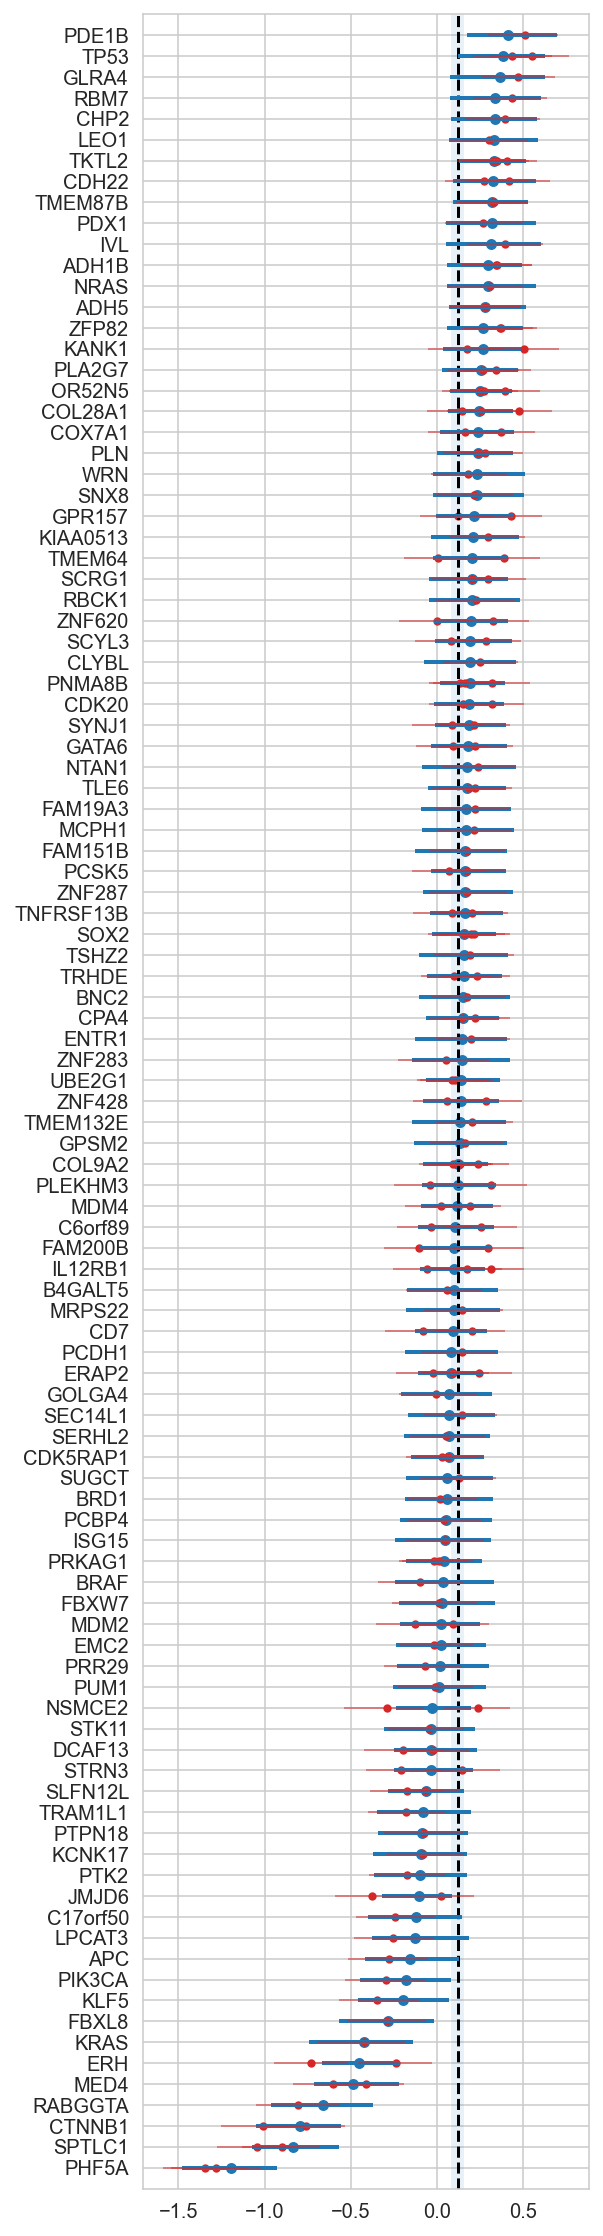

In [37]:
gene_order = (
    az.summary(trace, var_names=["mu_a"], kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol"])
    .sort_values("mean")["hugo_symbol"]
    .tolist()
)

sgrna_to_gene_map = (
    crc_data[["hugo_symbol", "sgrna"]].drop_duplicates().reset_index(drop=True)
)
a_post = (
    az.summary(trace, var_names=["a"], kind="stats")
    .pipe(extract_coords_param_names, names=["sgrna"])
    .reset_index(drop=True)
    .merge(sgrna_to_gene_map, on="sgrna", validate="one_to_one")
)
mu_a_post = (
    az.summary(trace, var_names=["mu_a"], kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol"])
    .reset_index(drop=True)
)

a_post["hugo_symbol"] = pd.Categorical(
    a_post["hugo_symbol"], categories=gene_order, ordered=True
)
a_post = a_post.sort_values("hugo_symbol").reset_index(drop=True)
mu_a_post["hugo_symbol"] = pd.Categorical(
    mu_a_post["hugo_symbol"], categories=gene_order, ordered=True
)
mu_a_post = mu_a_post.sort_values("hugo_symbol").reset_index(drop=True)

mu_mu_a_post = az.summary(trace, var_names=["mu_mu_a"], kind="stats")
assert len(mu_mu_a_post) == 1
mu_mu_a_avg = mu_mu_a_post["mean"][0]
mu_mu_a_hdi = (mu_mu_a_post["hdi_5.5%"][0], mu_mu_a_post["hdi_94.5%"][0])

fig, ax = plt.subplots(figsize=(4, 20))
# plt.axvline(0, color="grey")

# Population average and HDI
plt.fill_between(x=mu_mu_a_hdi, y1=-1, y2=len(mu_a_post), alpha=0.1)
plt.axvline(mu_mu_a_avg, color="k", linestyle="--")

# Gene estimates.
plt.hlines(
    y=mu_a_post["hugo_symbol"],
    xmin=mu_a_post["hdi_5.5%"],
    xmax=mu_a_post["hdi_94.5%"],
    color="tab:blue",
    linewidth=2,
)
plt.scatter(x=mu_a_post["mean"], y=mu_a_post["hugo_symbol"], s=20, c="tab:blue")

# sgRNA estimates.
plt.hlines(
    y=a_post["hugo_symbol"],
    xmin=a_post["hdi_5.5%"],
    xmax=a_post["hdi_94.5%"],
    color="tab:red",
    linewidth=1,
    alpha=0.5,
)
plt.scatter(x=a_post["mean"], y=a_post["hugo_symbol"], s=10, c="tab:red")

plt.ylim(-1, len(mu_a_post))
plt.show()

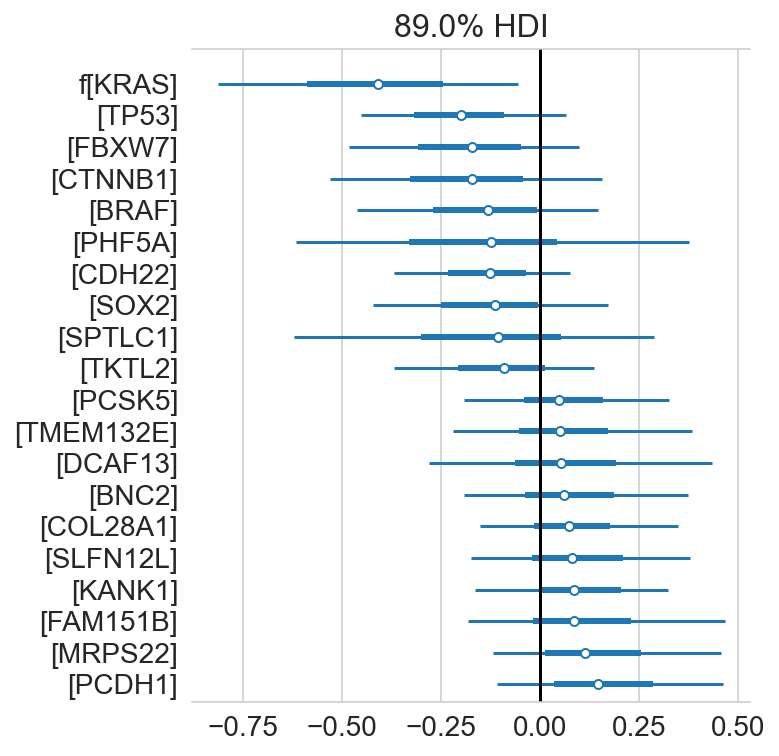

In [38]:
top_mut_effect_genes = (
    az.summary(trace, var_names=["f"])
    .sort_values("mean")
    .pipe(head_tail)
    .pipe(extract_coords_param_names, "hugo_symbol")["hugo_symbol"]
    .tolist()
)
ax = az.plot_forest(
    trace,
    var_names=["f"],
    coords={"gene": top_mut_effect_genes},
    combined=True,
    figsize=(5, 6),
)
ax[0].axvline(0, color="k")
plt.show()

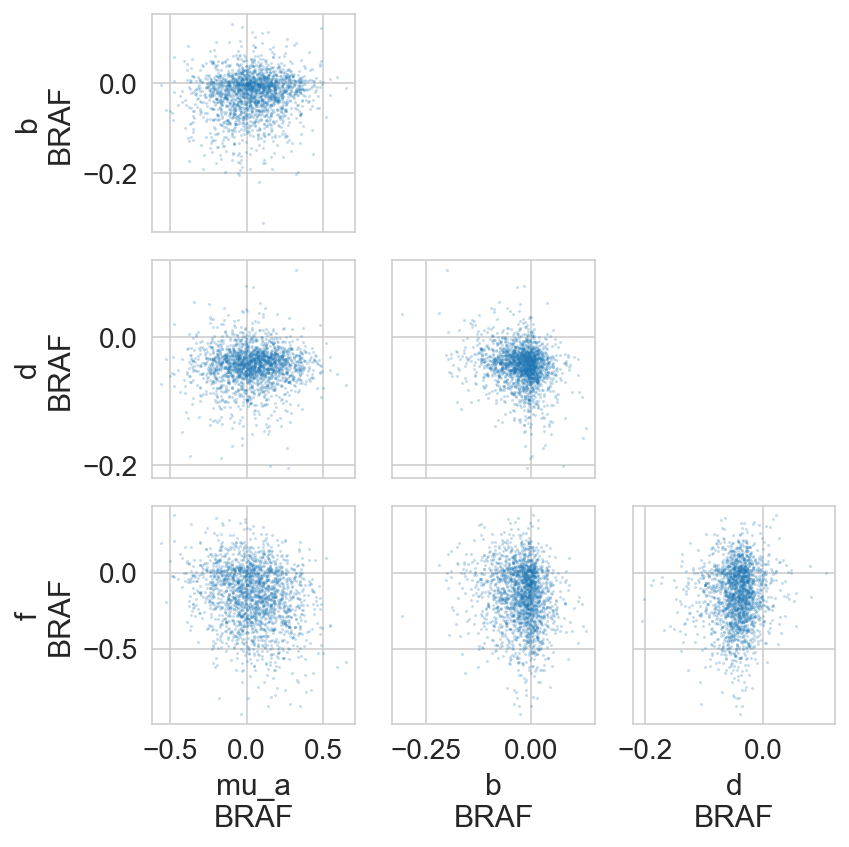

In [39]:
az.plot_pair(
    trace,
    var_names=["mu_a", "b", "d", "f"],
    coords={"gene": ["BRAF"]},
    scatter_kwargs={"alpha": 0.25, "markersize": 1},
    figsize=(6, 6),
)
plt.tight_layout()
plt.show()

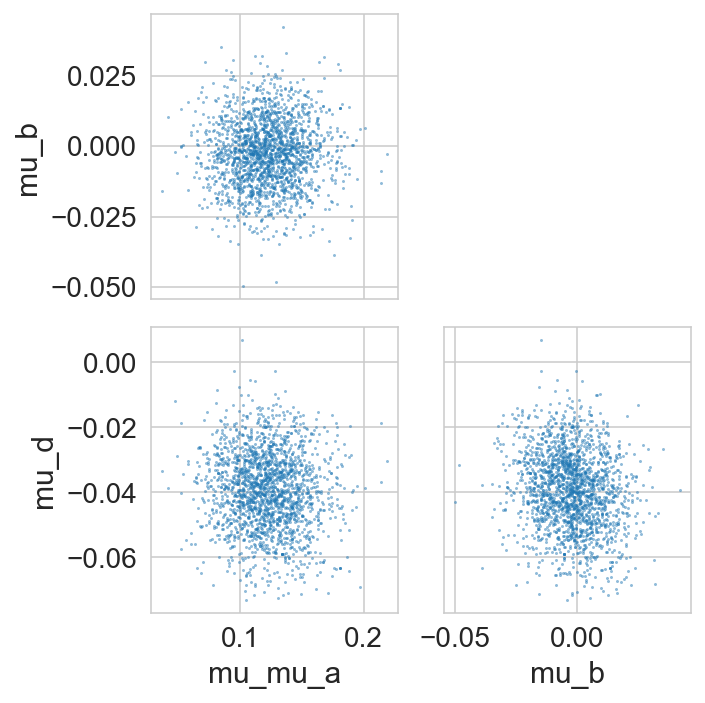

In [40]:
az.plot_pair(
    trace,
    var_names=["mu_mu_a", "mu_b", "mu_d"],
    scatter_kwargs={"alpha": 0.5, "markersize": 1},
    figsize=(5, 5),
)
plt.tight_layout()
plt.show()

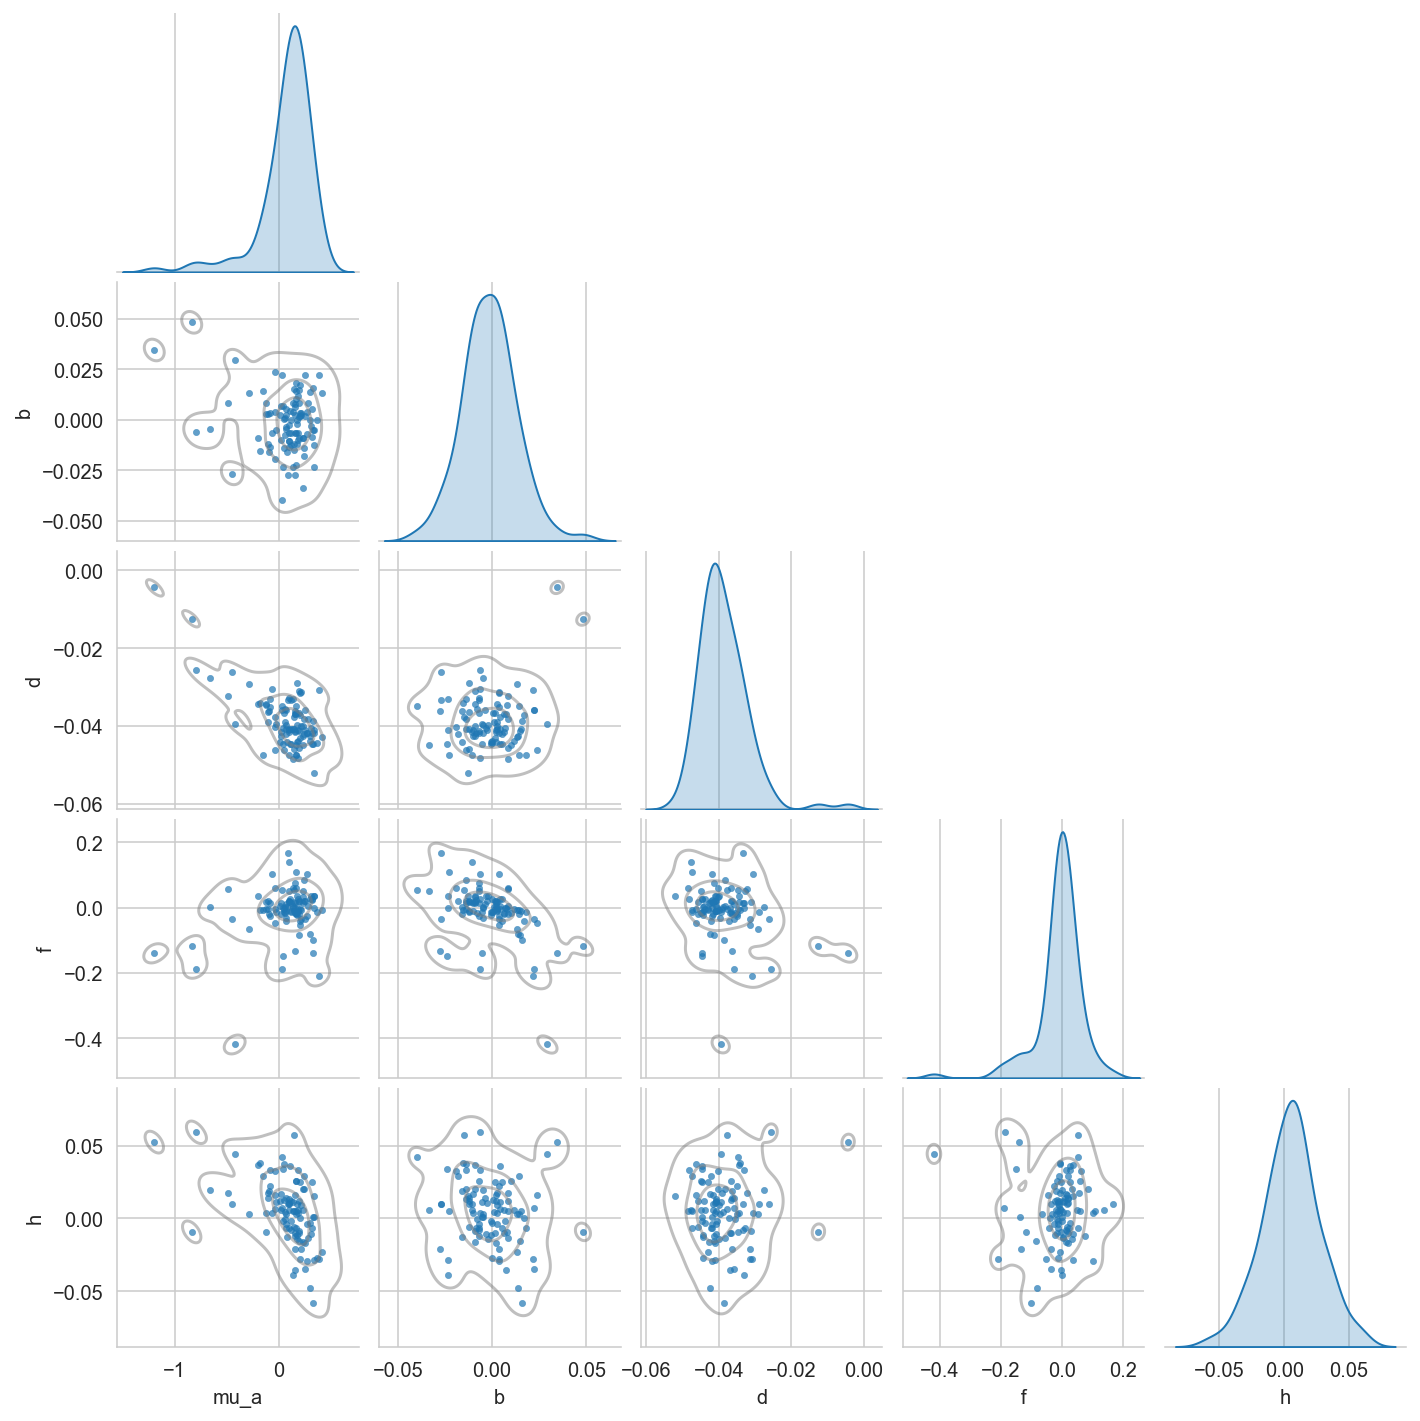

In [41]:
gene_effects = (
    trace.posterior.get(["mu_a", "b", "d", "f", "h"])
    .to_dataframe()
    .groupby(["gene"])
    .mean()
)
g = sns.pairplot(
    gene_effects,
    corner=True,
    diag_kind="kde",
    height=2,
    aspect=1,
    plot_kws={"edgecolor": None, "alpha": 0.7, "s": 10, "color": "tab:blue"},
)
g.map_lower(sns.kdeplot, levels=4, color="gray", alpha=0.5)
# g.map_lower(lambda *args, **kwargs: plt.gca().axhline(color="k", linewidth=0.7))
# g.map_lower(lambda *args, **kwargs: plt.gca().axvline(color="k", linewidth=0.7))
plt.show()

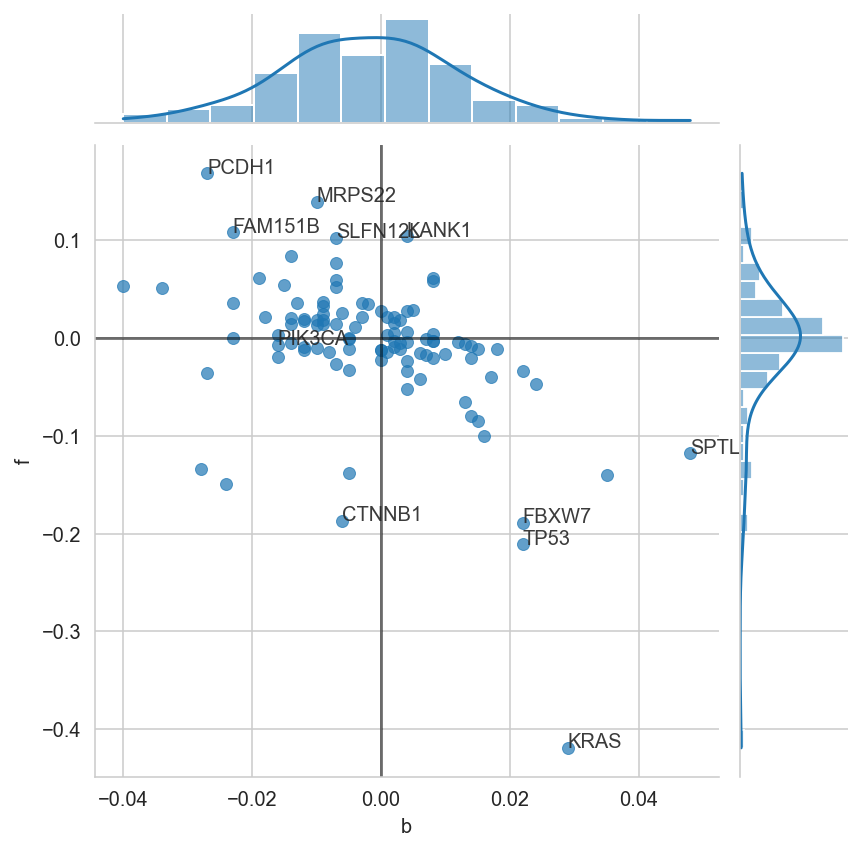

In [42]:
b_f_post = (
    az.summary(trace, var_names=["f", "b"])
    .pipe(extract_coords_param_names, names=["hugo_symbol"])
    .assign(var_name=lambda d: [x[0] for x in d.index.values])
    .pivot_wider("hugo_symbol", names_from="var_name", values_from="mean")
    .set_index("hugo_symbol")
)

jp = sns.jointplot(
    data=b_f_post,
    x="b",
    y="f",
    marginal_kws={"kde": True},
    joint_kws={"edgecolor": None, "alpha": 0.7},
)
ax = jp.ax_joint
ax.axhline(0, color="k", alpha=0.5)
ax.axvline(0, color="k", alpha=0.5)

genes_to_label = list(trace.posterior.coords["cancer_gene"].values)
genes_to_label += b_f_post[b_f_post["f"] < -0.15].index.tolist()
genes_to_label += b_f_post[b_f_post["f"] > 0.1].index.tolist()
genes_to_label += b_f_post[b_f_post["b"] < -0.04].index.tolist()
genes_to_label += b_f_post[b_f_post["b"] > 0.04].index.tolist()
genes_to_label = list(set(genes_to_label))
for gene in genes_to_label:
    data = b_f_post.query(f"hugo_symbol == '{gene}'")
    assert len(data) == 1
    ax.text(data["b"], data["f"], s=gene, alpha=0.9)


plt.show()

In [43]:
(
    valid_crc_data.filter_column_isin(
        "hugo_symbol", trace.posterior.coords["cancer_gene"].values
    )[["hugo_symbol", "depmap_id", "is_mutated"]]
    .drop_duplicates()
    .assign(is_mutated=lambda d: d["is_mutated"].map({True: "X", False: ""}))
    .pivot_wider("depmap_id", "hugo_symbol", "is_mutated")
    .set_index("depmap_id")
)

KRAS FBXW7 PIK3CA
depmap_id                   
ACH-000253                  
ACH-000286    X             
ACH-000296                  
ACH-000350    X             
ACH-000470    X     X       
ACH-000958          X      X
ACH-001786          X      X
ACH-002024    X            X

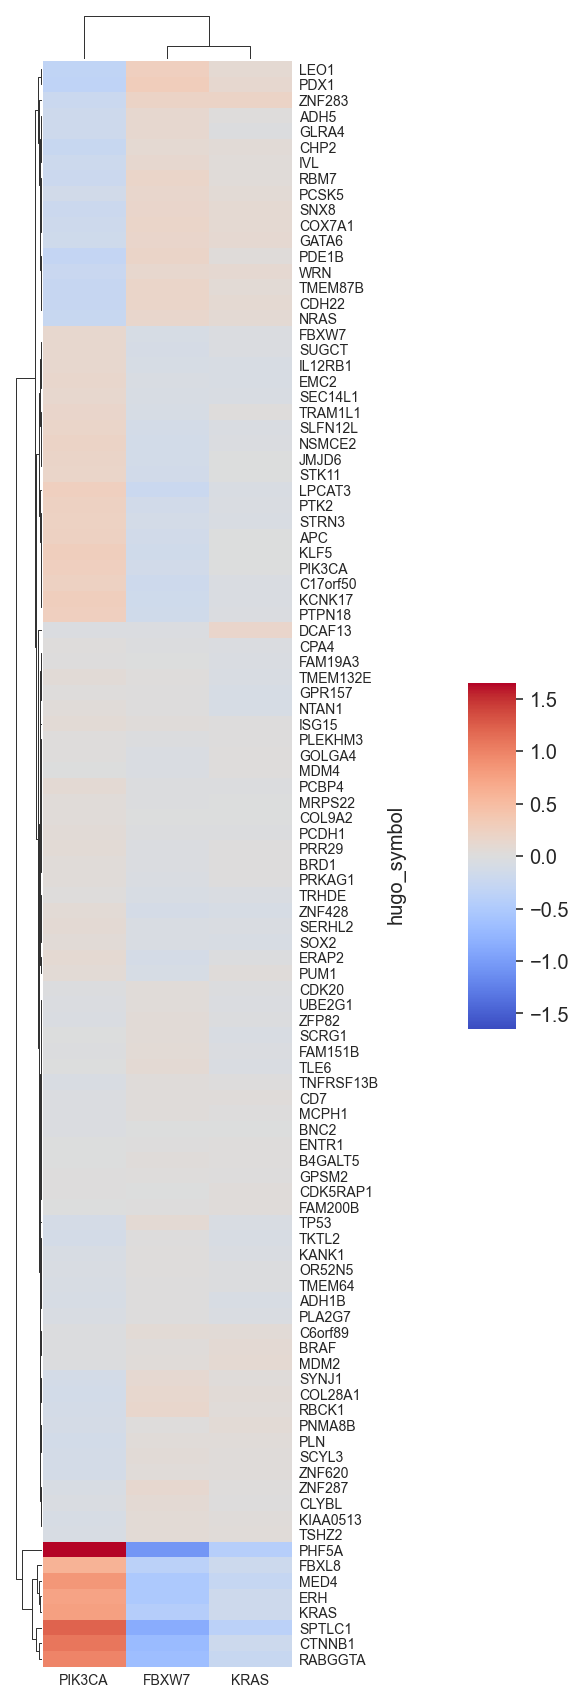

In [44]:
h_post_summary = (
    az.summary(trace, var_names="h", kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol", "cancer_gene"])
    .pivot_wider("hugo_symbol", names_from="cancer_gene", values_from="mean")
    .set_index("hugo_symbol")
)

vmax = np.abs(h_post_summary.values).max()

figsize = (3.3, 12)
dendro_ratio = (0.1, figsize[0] * 0.1 / figsize[1])
cm = sns.clustermap(
    h_post_summary,
    z_score=None,
    cmap="coolwarm",
    vmin=-vmax,
    vmax=vmax,
    figsize=figsize,
    dendrogram_ratio=dendro_ratio,
    cbar_pos=(1, 0.4, 0.1, 0.2),
    yticklabels=1,
)
cm.ax_heatmap.tick_params("both", labelsize=7, size=0)
plt.show()

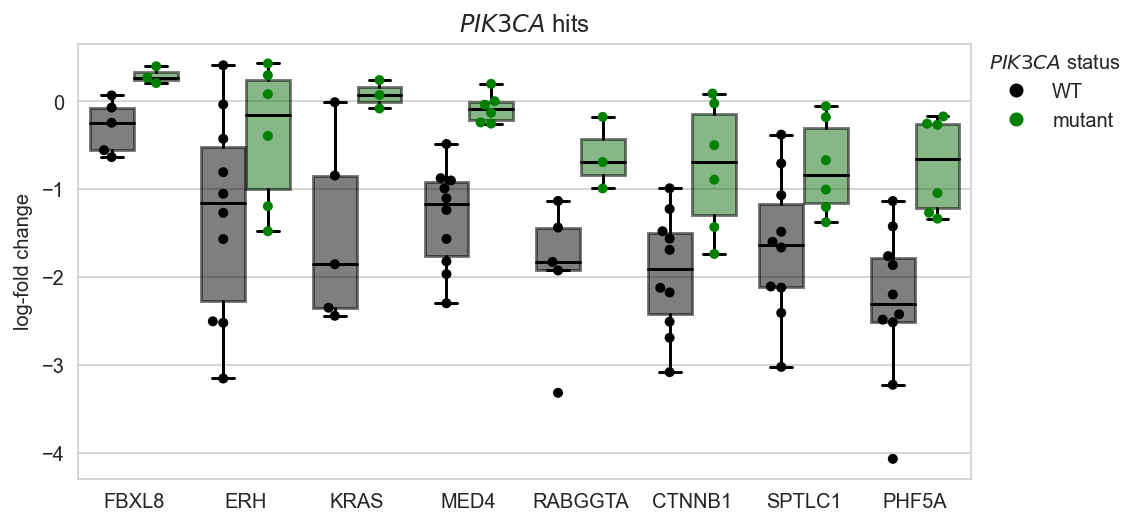

In [45]:
pik3ca_hits = h_post_summary.sort_values("PIK3CA").query("PIK3CA > 0.5").index.tolist()

pik3ca_mut_map = (
    crc_data.copy()
    .query("hugo_symbol == 'PIK3CA'")[["depmap_id", "is_mutated"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .rename(columns={"is_mutated": "pik3ca_mut"})
)

pik3ca_hits_data = (
    crc_data.copy()
    .filter_column_isin("hugo_symbol", pik3ca_hits)
    .merge(pik3ca_mut_map, on="depmap_id")
    .reset_index(drop=True)
    .assign(
        hugo_symbol=lambda d: pd.Categorical(
            d["hugo_symbol"], categories=pik3ca_hits, ordered=True
        )
    )
)

pal = {
    False: "k",
    True: "g",
}

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    data=pik3ca_hits_data,
    x="hugo_symbol",
    y="lfc",
    hue="pik3ca_mut",
    palette=pal,
    dodge=True,
    ax=ax,
    flierprops={"markersize": 0},
    boxprops={"alpha": 0.5},
)
sns.swarmplot(
    data=pik3ca_hits_data,
    x="hugo_symbol",
    y="lfc",
    hue="pik3ca_mut",
    dodge=True,
    ax=ax,
    palette=pal,
)

ax.set_title("$\mathit{PIK3CA}$ hits")
ax.set_xlabel(None)
ax.set_ylabel("log-fold change")
ax.get_legend().remove()

leg_lbl = {True: "mutant", False: "WT"}
leg_handles = [
    Line2D([0], [0], linewidth=0, marker="o", color=v, label=leg_lbl[k])
    for k, v in pal.items()
]
ax.legend(
    handles=leg_handles,
    loc="upper left",
    bbox_to_anchor=(1, 1.02),
    title="$\mathit{PIK3CA}$ status",
    frameon=False,
)

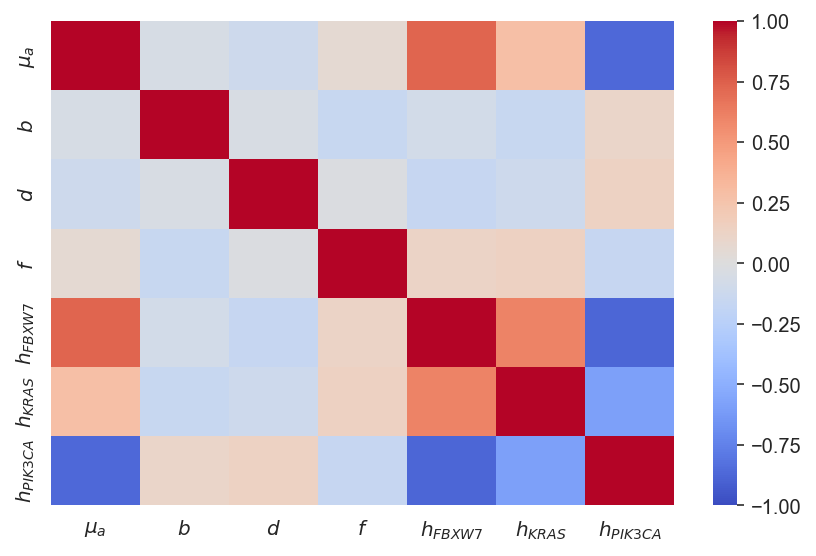

In [46]:
gene_vars = ["$\mu_a$", "$b$", "$d$", "$f$"]
gene_vars += ["$h_{" + g + "}$" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, var_names=["genes_chol_cov_corr"], kind="stats")
    .pipe(extract_coords_param_names, names=["d0", "d1"])
    .astype({"d0": int, "d1": int})
    .assign(
        p0=lambda d: [gene_vars[i] for i in d["d0"]],
        p1=lambda d: [gene_vars[i] for i in d["d1"]],
    )
)

plot_df = gene_corr_post.pivot_wider(
    "p0", names_from="p1", values_from="mean"
).set_index("p0")
ax = sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.tight_layout()
plt.show()

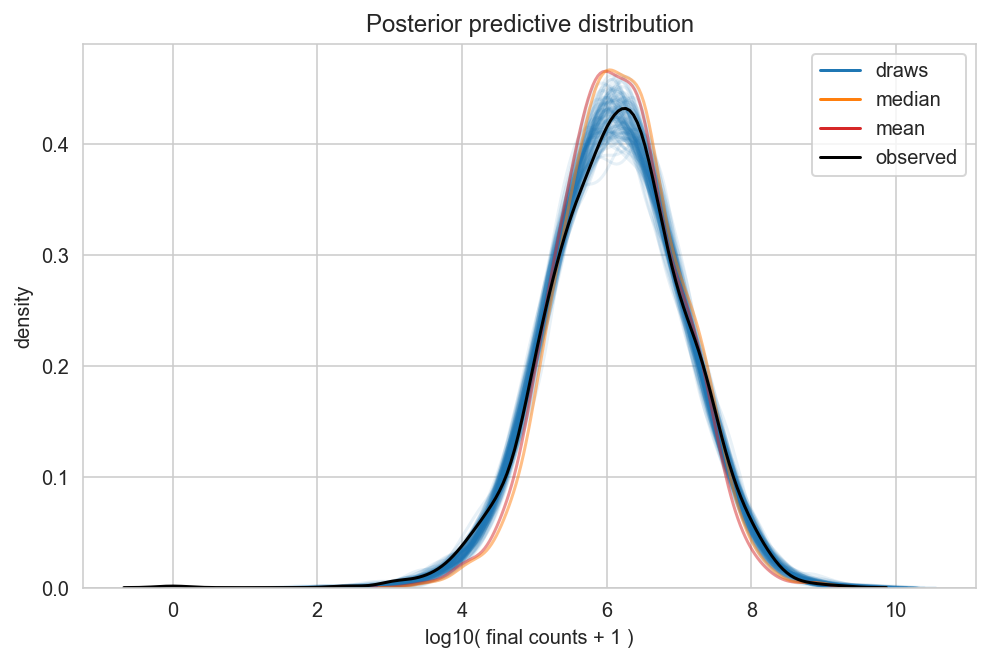

In [47]:
N = 100

pp_dist = trace.posterior_predictive["ct_final"]
n_chains, n_draws, n_samples = pp_dist.shape
draws_idx = np.random.choice(np.arange(n_draws), N // n_chains, replace=False)

fig, ax = plt.subplots(figsize=(8, 5))

ppc_pal = {
    "draws": "tab:blue",
    "median": "tab:orange",
    "mean": "tab:red",
    "observed": "black",
}

# Example draws.
for c, d in product(range(n_chains), draws_idx):
    values = np.log(pp_dist[c, d, :].values + 1)
    sns.kdeplot(values, color=ppc_pal["draws"], alpha=0.1, ax=ax)

# Average distributions.
pp_dist_mean = np.log(pp_dist.median(axis=(0, 1)) + 1)
pp_dist_mid = np.log(pp_dist.mean(axis=(0, 1)) + 1)
sns.kdeplot(pp_dist_mean, color=ppc_pal["mean"], ax=ax, alpha=0.5)
sns.kdeplot(pp_dist_mid, color=ppc_pal["median"], ax=ax, alpha=0.5)

# Observed distribution.
sns.kdeplot(
    np.log(trace.observed_data["ct_final"] + 1), ax=ax, color=ppc_pal["observed"]
)

ppc_leg_handles: list[Line2D] = []
for lbl, color in ppc_pal.items():
    ppc_leg_handles.append(Line2D([0], [0], color=color, label=lbl))

plt.legend(handles=ppc_leg_handles, loc="best")


ax.set_xlabel("log10( final counts + 1 )")
ax.set_ylabel("density")
ax.set_title("Posterior predictive distribution")
plt.show()

In [48]:
# az.plot_forest(trace, var_names=["b", "f"], combined=True)
# plt.show()

---

In [49]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 3.64 minutes


In [50]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-29

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: simplify

pandas    : 1.4.3
arviz     : 0.12.1
pymc      : 4.1.3
seaborn   : 0.11.2
numpy     : 1.23.0
aesara    : 2.7.7
plotnine  : 0.0.0
matplotlib: 3.5.2

